# Fraud: A How-To Guide

In [1]:
import pandas as pd

In [2]:
from sklearn.neighbors.kde import KernelDensity
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from numpy import genfromtxt
from collections import Counter
from datetime import datetime
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)
data = genfromtxt('anonymized_finance.csv', dtype = str , delimiter=',')
data = np.delete(data, (0), axis=0)
data = pd.DataFrame(data)
data.columns = ["Date", "Amount"]
from dateutil.parser import *
def extract_day(row):
    datestring = row['Date']
    date = datetime.strptime(str(datestring), "%d%b%Y")
    return date.day
def extract_month(row):
    datestring = row['Date']
    date = datetime.strptime(str(datestring), "%d%b%Y")
    return date.month
def extract_year(row):
    datestring = row['Date']
    date = datetime.strptime(str(datestring), "%d%b%Y")
    return date.year
data = data.assign(Days = data.apply(extract_day, axis=1))
data = data.assign(Month = data.apply(extract_month, axis=1))
data = data.assign(Year = data.apply(extract_year, axis=1))
data['Amount'] = pd.to_numeric(data['Amount'], errors='coerce').fillna(0)



Exploratory analysis: I wanted to see if there was seasonal variation in the data. Therefore I totalled the number of transactions in each month in each year and presented in the data frame below. There doesn't seem to be variation within a particular month. For example, the number of transactions in December from 2013 to 2017 are 27, 106, 45, 73, 34. If anything, there seems to be an alternating, cyclical pattern in the number of transactions every year, where one year is busy and the next less so. Furthermore, there seems to be auto-correlation in the number of transactions monthly. Busy months tend to follow busy months and less busy months tend to follow less busy months.

In [3]:
from collections import Counter
monthly_histogram = data.groupby(["Year", "Month"]).count()
monthly_histogram

Date  Amount  Days
Year Month                    
2013 9        10      10    10
     10       16      16    16
     11        8       8     8
     12       27      27    27
2014 1        40      40    40
     2        36      36    36
     3        43      43    43
     4        33      33    33
     5        44      44    44
     6        52      52    52
     7        53      53    53
     8        41      41    41
     9        55      55    55
     10       44      44    44
     11       52      52    52
     12      106     106   106
2015 1        96      96    96
     2        58      58    58
     3        64      64    64
     4        51      51    51
     5        64      64    64
     6        73      73    73
     7        59      59    59
     8        64      64    64
     9        54      54    54
     10       59      59    59
     11       23      23    23
     12       45      45    45
2016 1        48      48    48
     2        39      39    39
     3        40      40    40
     4        32      32    32
     5        38      38    38
     6        38      38    38
     7        32      32    32
     8        45      45    45
     9        68      68    68
     10       57      57    57
     11       86      86    86
     12       73      73    73
2017 1        59      59    59
     2        62      62    62
     3        88      88    88
     4        78      78    78
     5        75      75    75
     6        61      61    61
     7        47      47    47
     8        48      48    48
     9        34      34    34

I create a time series plot of the number of transactions per month as a function of the number of months since September 2013, which is when we start getting data. We can clearly see the autocorrelation in the data. Therefore, this suggests one of the possible flaws in our model. When we start faking transactional data we need previous data. If our initial number of transactions is drastically different from the previous month, this could raise a red flag. Even though sharp changes in the data exist (for example at around the 25th and 26th months), a lot of these points can raise suspicion, especially if we are not creating continuous chunks of data but must recreate segments of missing data. If we have data from previous months, we can use a Gaussian process to interpolate the number of transactions between periods where we have data. If we are trying to extrapolate data for future years, a Gaussian process can be a bad choice because the variance for these points are high because we don't have data for the future. We can try fitting a linear parameter model with a sinusoidal feature space due to the cyclical pattern seen in the data.

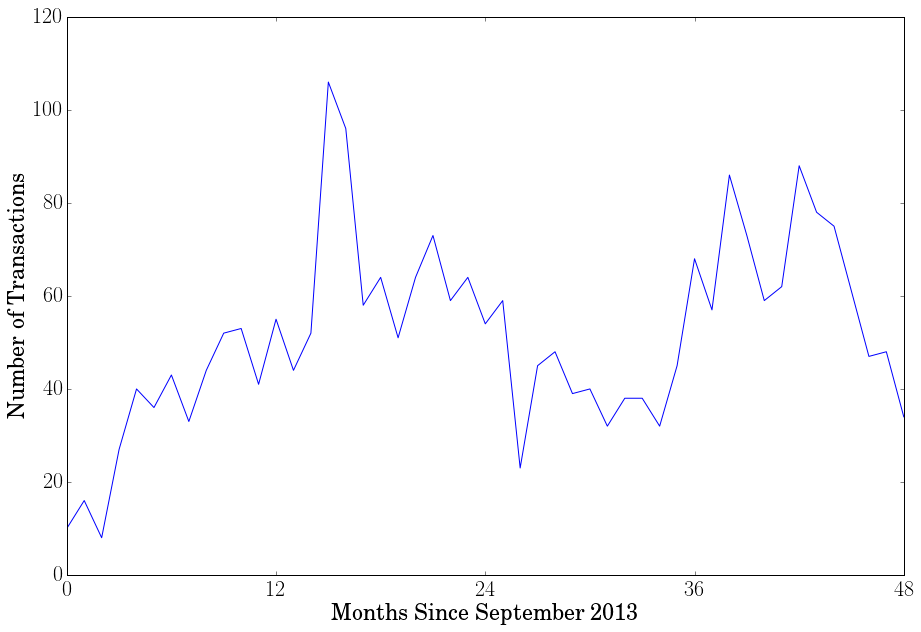

In [4]:
plt.figure(figsize=(15,10))
plt.xticks(np.arange(0,50,12))
plt.xlabel("Months Since September 2013")
plt.ylabel("Number of Transactions")
plt.plot(range(len(monthly_histogram.iloc[:]['Date'])), monthly_histogram.iloc[:]['Date'])
plt.show()

Because I have determined that there is little correlation between the month of year and the number of transactions, I can simply create a histogram of the number of transactions per month and fit a density model without having to fit separate density models for each month.

(49, 1)
(100, 1)


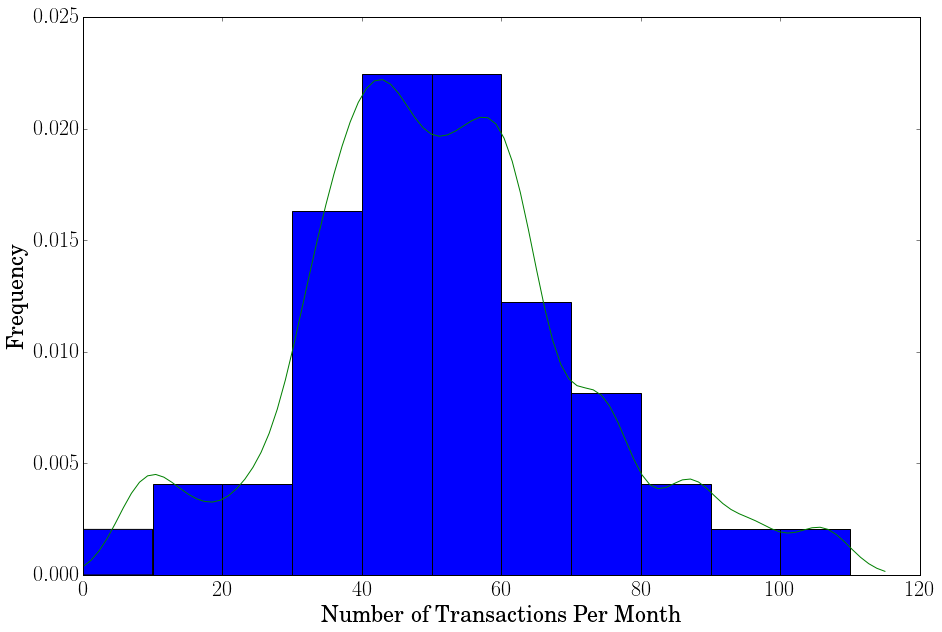

In [5]:
plt.figure(figsize=(15,10))
plt.ylabel("Frequency")
plt.xlabel("Number of Transactions Per Month")
plt.hist(monthly_histogram["Date"],np.arange(0,120,10), normed=1)
X = monthly_histogram["Date"][:, np.newaxis]
print X.shape
transactions_per_month_kde = KernelDensity(kernel='gaussian', bandwidth=4).fit(X)
X_plot = (np.linspace(0,115,100))[:, np.newaxis]
print X_plot.shape
log_dens = transactions_per_month_kde.score_samples(X_plot)
plt.plot(X_plot, np.exp(log_dens))
plt.show()

Here I create a density model of the distribution of days that the transaction happend on. I wanted to see if there could have been differences in these distributions, depending on whether the month was a busy month or if the month was a slower month. Below is the density estimated for all months. We can see that this curve is bimodal, with more transactions occurring at the beginning of the month and at the end of the month. However, we can also think of this as cyclical, as the number of transactions might spike within a few days at the end of a month and the beginning of the next one.

(100, 1)


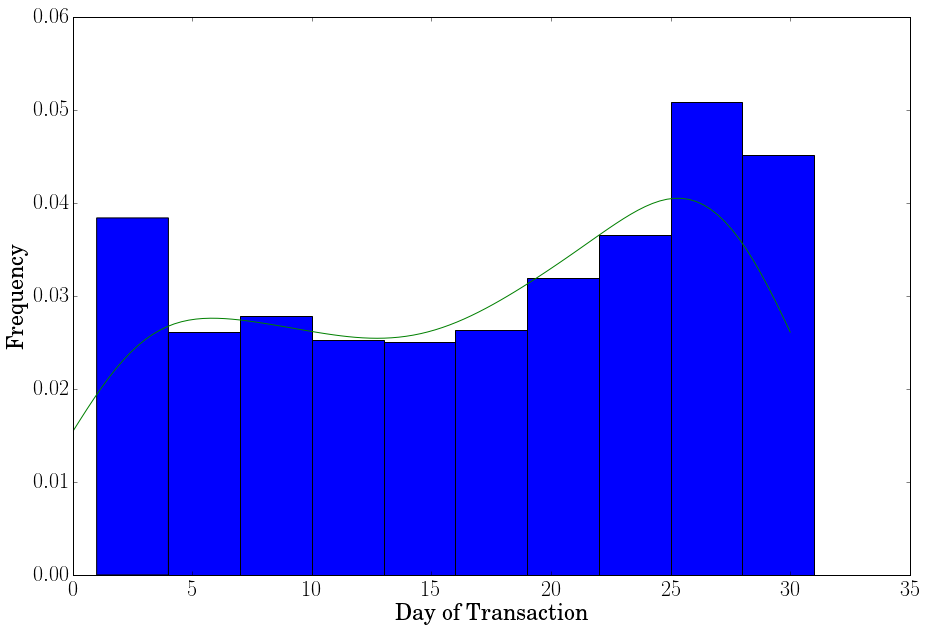

In [6]:
many_transactions = list(monthly_histogram[monthly_histogram["Date"] > 0].index)
many_transactions_df = pd.DataFrame(columns=data.columns)
for i in many_transactions:
    many_transactions_df = pd.concat((many_transactions_df, data[(data["Year"] == i[0]) & (data["Month"] == i[1])]))
daily_histogram = many_transactions_df.groupby(["Days"]).count()
daily_histogram["Date"]

plt.figure(figsize=(15,10))
plt.ylabel("Frequency")
plt.xlabel("Day of Transaction")
daily_data = np.array(many_transactions_df["Days"])
plt.hist(daily_data, normed = 1)

X = daily_data[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=3).fit(X)
X_plot = (np.linspace(0,30,100))[:, np.newaxis]
log_dens = kde.score_samples(X_plot)
plt.plot(X_plot, np.exp(log_dens))

print X_plot.shape
plt.show()

I plotted the density estimated for months with fewer than 60 transactions. We can see that this curve has much more pronounced modes and thus larger variance

(100, 1)


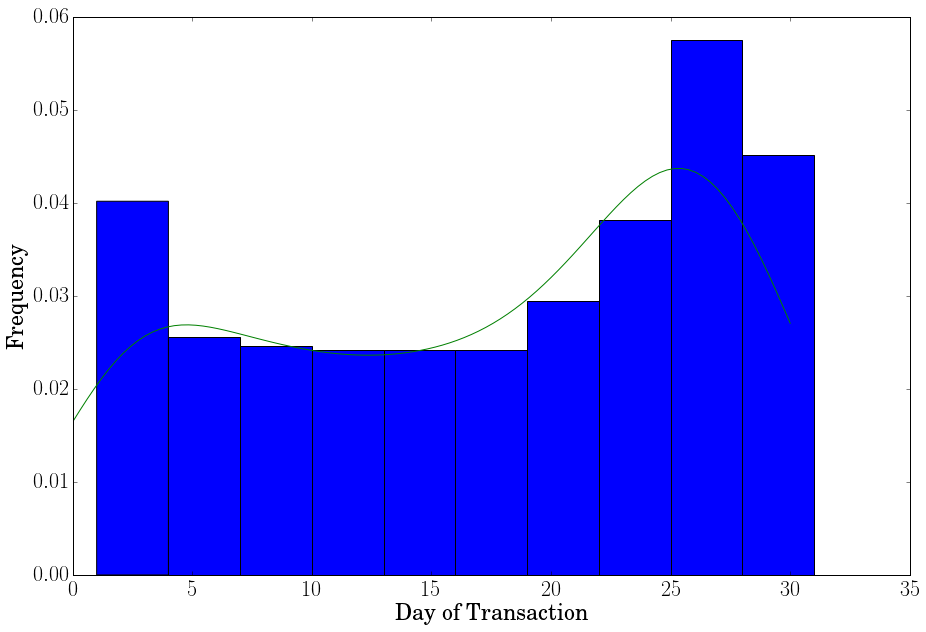

In [7]:
many_transactions = list(monthly_histogram[monthly_histogram["Date"] < 60].index)
many_transactions_df = pd.DataFrame(columns=data.columns)
for i in many_transactions:
    many_transactions_df = pd.concat((many_transactions_df, data[(data["Year"] == i[0]) & (data["Month"] == i[1])]))
daily_histogram = many_transactions_df.groupby(["Days"]).count()
daily_histogram["Date"]

plt.figure(figsize=(15,10))
plt.ylabel("Frequency")
plt.xlabel("Day of Transaction")
daily_data = np.array(many_transactions_df["Days"])
plt.hist(daily_data, normed = 1)

X = daily_data[:, np.newaxis]
slow_month_kde = KernelDensity(kernel='gaussian', bandwidth=3).fit(X)
X_plot = (np.linspace(0,30,100))[:, np.newaxis]
print X_plot.shape
log_dens = slow_month_kde.score_samples(X_plot)
plt.plot(X_plot, np.exp(log_dens))
plt.show()

For months with greater than 60 transactions we can see that the distribution of number of transactions per day is much more uniform, even if we can still discern a spike at the beginning and end of these months. A flaw of the model is that I visually created the 60 days threshold. A better model would be better able to learn the conditional probability distribution of days of transaction depending on how busy the month was. This flaw can be exploited by the forensic accountant by searching for more fine-grained irregularities that my model produces because I did not model this conditional distribution.

(100, 1)


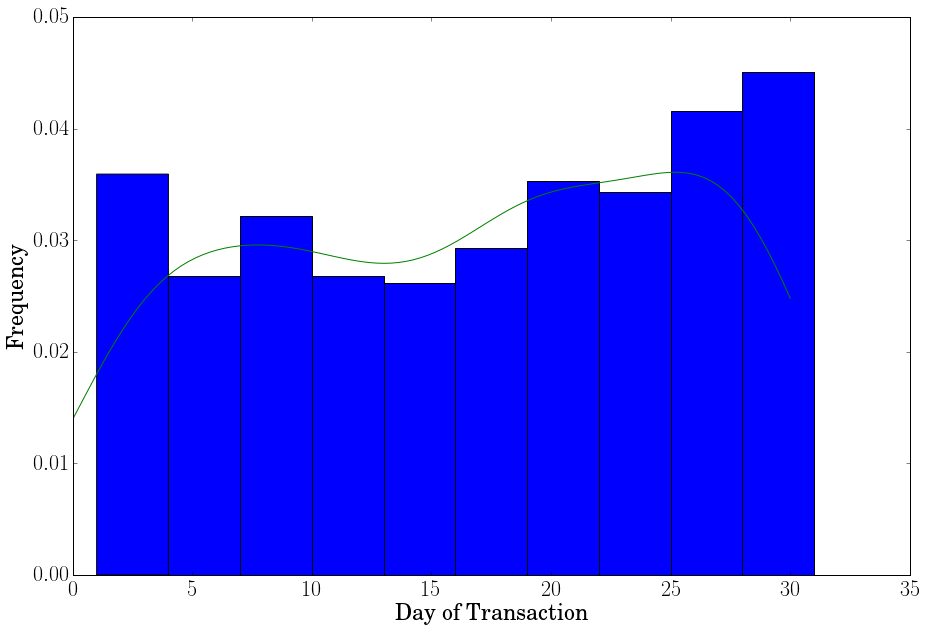

In [8]:
many_transactions = list(monthly_histogram[monthly_histogram["Date"] > 60].index)
many_transactions_df = pd.DataFrame(columns=data.columns)
for i in many_transactions:
    many_transactions_df = pd.concat((many_transactions_df, data[(data["Year"] == i[0]) & (data["Month"] == i[1])]))
daily_histogram = many_transactions_df.groupby(["Days"]).count()
daily_histogram["Date"]

plt.figure(figsize=(15,10))
plt.ylabel("Frequency")
plt.xlabel("Day of Transaction")
daily_data = np.array(many_transactions_df["Days"])
plt.hist(daily_data, normed = 1)

X = daily_data[:, np.newaxis]
busy_month_kde = KernelDensity(kernel='gaussian', bandwidth=3).fit(X)
X_plot = (np.linspace(0,30,100))[:, np.newaxis]
print X_plot.shape
log_dens = busy_month_kde.score_samples(X_plot)
plt.plot(X_plot, np.exp(log_dens))
plt.show()

Here I model the distribution of the signed log transaction sizes, which is the log of the absolute value of transaction sizes, taking on a negative value if the number is negative.

(array([ 0.01822624,  0.08947425,  0.09113118,  0.10438662,  0.13918216,
        0.3363569 ,  0.28830591,  0.42417422,  0.53850242,  0.44405738,
        0.3529262 ,  0.39103561,  0.24853958,  0.08450346,  0.03976633,
        0.04308019,  0.03976633,  0.00497079,  0.00165693,  0.00331386,
        0.00165693,  0.        ,  0.01159851,  0.03148168,  0.01988317,
        0.03148168,  0.01325544,  0.00994158,  0.00662772,  0.01822624,
        0.00165693,  0.02485396,  0.02485396,  0.03479554,  0.03976633,
        0.03645247,  0.0762188 ,  0.04639405,  0.0596495 ]), array([-4.61336553, -4.37368101, -4.1339965 , -3.89431199, -3.65462747,
       -3.41494296, -3.17525845, -2.93557393, -2.69588942, -2.45620491,
       -2.21652039, -1.97683588, -1.73715137, -1.49746686, -1.25778234,
       -1.01809783, -0.77841332, -0.5387288 , -0.29904429, -0.05935978,
        0.18032474,  0.42000925,  0.65969376,  0.89937828,  1.13906279,
        1.3787473 ,  1.61843182,  1.85811633,  2.09780084,  2.33748536,
  

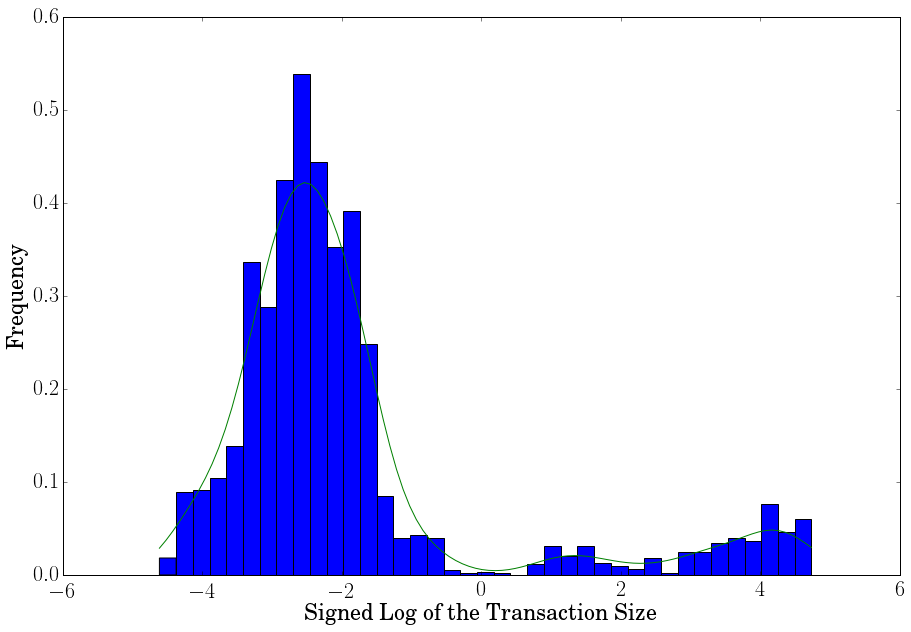

In [9]:
plt.figure(figsize=(15,10))
plt.ylabel("Frequency")
plt.xlabel("Signed Log of the Transaction Size")
# amount_data = np.clip(np.log(np.array(data["Amount"], dtype=float)), 
amount_data = (np.array(data["Amount"], dtype=float))
amount_data = np.sign(amount_data) * np.log10(abs(amount_data))
print plt.hist(amount_data, np.linspace(min(amount_data), max(amount_data), 40), normed = 1)

X = amount_data[:, np.newaxis]
log_transaction_size_kde = KernelDensity(kernel='gaussian', bandwidth=0.4).fit(X)
X_plot = (np.linspace(min(X),max(X),100))[:, np.newaxis]
# print X_plot.shape
log_dens = log_transaction_size_kde.score_samples(X_plot)
plt.plot(X_plot, np.exp(log_dens))
plt.show()

By visually inspecting the data, it seems that there is a dependence of the amount of money on the time of month. Big transactions tend to come in the middle of the month, perhaps as payment. I will learn a 2-dimensional density with days and amount, so that the model can learn these dependencies. 

In [10]:
z = np.array(data[["Amount", "Days"]], dtype=float)
density = KernelDensity(kernel='gaussian', bandwidth=4).fit(z)

To visualize the 2D distribution being learned, I shall plot the 2D Histogram of signed log of transaction amount and the day of transaction. We can clearly see the bimodal distribution in log-scale where there are very few deposits that are positive and less than 100 dollars.

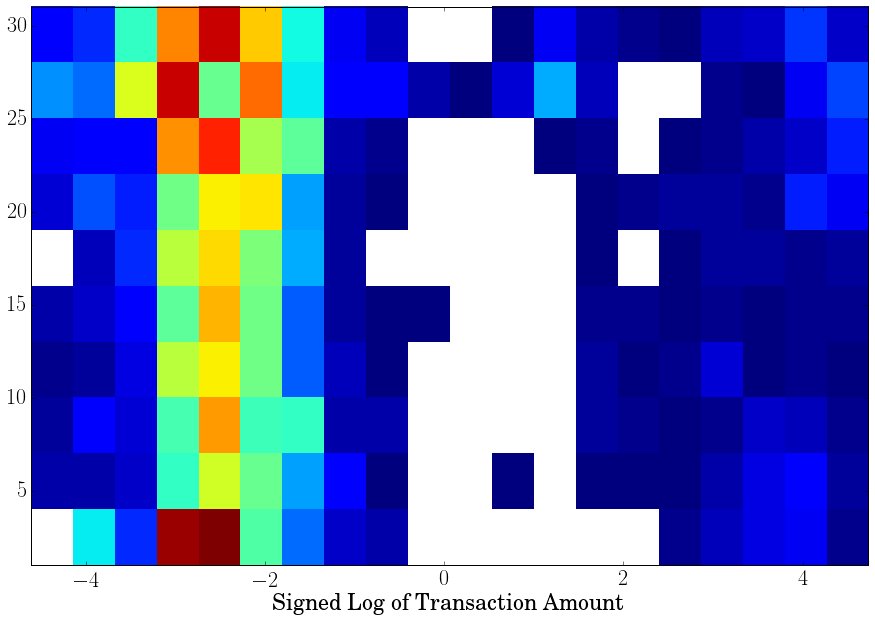

In [11]:
z_log_amount = z.copy()
z_log_amount[:,0] = np.sign(z_log_amount[:,0]) * np.log10(abs(z_log_amount[:,0]))  
plt.figure(figsize=(15,10))
plt.hist2d(z_log_amount[:,0], z_log_amount[:,1], [20,10], cmin=1)
plt.xlabel("Signed Log of Transaction Amount")
plt.show()

To generate fake transaction data for a month, I first sample the number of transactions per month. Then I sample the days and amount of transactions.

In [19]:
num_transaction = transactions_per_month_kde.sample(1)
num_transaction = int(np.round(num_transaction[0,0]))
print "The number of transactions in this month is:", num_transaction
pd.set_option('display.max_rows', 500)
samples = density.sample(num_transaction)
samples[:,1] = np.round(np.clip(samples[:,1], 1, 31))
samples = pd.DataFrame(samples) 
samples.columns = ["Amount", "Days"]
samples.sort(["Days"])


The number of transactions in this month is: 61


/Users/alng/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Amount,Days
15,-362.877386,1
1,-1499.652242,1
48,-53.916056,1
26,1100.973124,1
32,-131.809710,1
23,-863.612413,1
6,-358.698622,1
8,-315.465662,1
21,-347.552855,1
37,-862.261964,1


If I have more time, to make the model better, I would figure out how to make the input data of the same scale. Currently the bandwidth parameter of 4 applies to both the amount and the days of transaction. This is reasonably smooth for the days variable but is too bumpy for the amount variable.

# Book reviews and how to fake them

I chose Plato's *The Republic* as a book I want to be pretend to have read.

In [13]:
import string
import textwrap
import pandas as pd
from time import time
from nltk.corpus import stopwords
from collections import OrderedDict
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [14]:
with open("republic.txt", 'r') as book:
    t = book.readlines()[45:24281] #without the Gutenberg text
    indices = [i for i, x in enumerate(t) if x == "\r\n"] #paragraphs have \r\n between them
    paragraphs = ["".join(t[indices[i]:indices[i+1]]) for i in range(len(indices)-1)] 
    # split into paragraphs
    paragraphs = [paragraph for paragraph in paragraphs if len(paragraph) > 5]
    sw = set(stopwords.words('english'))
    processed = []
    for i in range(len(paragraphs)):
        no_punc = paragraphs[i].translate(None, string.punctuation).lower() #remove punctuation
        no_stopwords = [word for word in no_punc.split() if word not in sw] # remove stopwords
        no_stopwords = " ".join(no_stopwords) 
        processed.append(no_stopwords) #add result to a list

In [18]:
for i in range(3):
    print processed[i], "\n"

republic plato longest works exception laws certainly greatest nearer approaches modern metaphysics philebus sophist politicus statesman ideal form institutions state clearly drawn laws works art symposium protagoras higher excellence dialogue plato largeness view perfection style shows equal knowledge world contains thoughts new well old one age nowhere plato deeper irony greater wealth humour imagery dramatic power writings attempt made interweave life speculation connect politics philosophy republic centre around dialogues may grouped philosophy reaches highest point cp especially books v vi vii ancient thinkers ever attained plato among greeks like bacon among moderns first conceived method knowledge although neither always distinguished bare outline form substance truth content abstraction science yet realized greatest metaphysical genius world seen ancient thinker germs future knowledge contained sciences logic psychology supplied many instruments thought afterages based upon ana

Because the words used in Plato's The Republic are common words (the argument is in the structure, not the content!), having just a few words give me little idea of the main topic discussed. Therefore, I choose to print 30 words instead of 10 to better understand the topics. I also decided to train 30 topics rather than 10 topics because there seems to be a clear delineation into topics for 30 topics. I decided to not throw away any words and use the full document-word matrix, because of these simple word choices. I choose batch training because the words in the topic seem much more globally related to one another. We can clearly see topics that have to do with mathematics, epistemology (topics dealing mainly with knowledge), ethics (the topics dealing mainly with justice and good and evil), the topics dealing with light analogies...

In [16]:
n_top_words = 30
n_topics = 30


# Reassigns the chapters
print("Loading dataset...")
t0 = time()
data_samples = processed#[]
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_features=3000)

t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))


lda = LatentDirichletAllocation(n_topics = n_topics, max_iter = 10,
                                learning_method = 'batch',
                                learning_offset = 50.,
                                random_state = 0)

# Fits the data using the LDA model
# Times how long it takes
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

# Defines the function that will print out the top words
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

# Prints the topics and their corresponding top words
print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Loading dataset...
done in 0.000s.
Extracting tf features for LDA...
done in 0.322s.


/Users/alng/anaconda/lib/python2.7/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


done in 10.038s.

Topics in LDA model:
Topic #0: replied number first numbers greek glaucon us one perfect two square state also terms cubed children answer times gold pythagorean polemarchus thrasymachus three ie divine second shall government power 100
Topic #1: one impossible good man work qualities men great reverse say many like may would well latter guardian two seen female appear absolute another works zeus things far upon male horses
Topic #2: true number would love harmony book philosophers also lovers ideal removed perfect life state figure matters well used said human philosopher may numbers soul called shadow image certain every concerned
Topic #3: one say another man philosophy natures men nature time others us upon may like grow either said let different rest see image words less many two mind every true never
Topic #4: justice man unjust good one injustice evil would men life nature like shall say first therefore gods better also us whether virtue let others soul another

Even though the empirical sciences allow us to help our friends and destroy our enemies, we can only understand justice through the light of reason. The perfection of mathematics come from the divine knowledge that justifies the possibility of government. True numerical facts are harmonious with the good, and the great philosophers are the guardians of truth. Every mind can see the certainty of mathematics with education. Education through philosophy teaches men and women virtues that help them distinguish between good and evil. A good education also requires music and gymnastics because a good soul is a soul that is youthful and beautful. 